- Compare HSI emissions with Climate TRACE inventory and available literatural observation results

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import string
import numpy as np
from sklearn.linear_model import LinearRegression
import leafmap.foliumap as leafmap

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
# --- summary data ---
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv', dtype={'metadata_report_year': str})
# convert units from t/h to Gg/yr
df_summary['emission'] = df_summary['emission'] / 1e3 * 365 *24
# convert units from t/yr to Gg/yr
df_summary['emissions_quantity'] /= 1e3

# --- climate trace top 20 ---
df_climatetrace = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'metadata_report_year': str}, sheet_name='ClimateTrace_TOP20')
# convert units from t/yr to Gg/yr
df_climatetrace['emissions_quantity'] /= 1e3

# --- all HSI plume OBS ---
df_hyper_top20 = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')
# remove space at end
df_hyper_top20['name'] = df_hyper_top20['name'].str.strip()

# --- ground OBS data ---
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx', dtype={'year': str}, sheet_name='OBS')
# convert units from t/h to Gg/yr
df_obs['emission_obs'] = df_obs['emission(t/h)'] / 1e3 * 365 *24
df_obs['uncertainty_obs'] = df_obs['uncertainty(t/h)'] / 1e3 * 365 *24

## Overview Folium Map

In [4]:
m = leafmap.Map()
m.add_basemap("Esri.WorldImagery")

# m.add_circle_markers_from_xy(geo_df_large, x="lon", y="lat", radius=5, color="none", fill_color='blue', fill_opacity=0.6, popup=['lon', 'lat', 'emissions_quantity', 'asset_name', 'iso3_country', 'start_time', 'end_time'])
m.add_circle_markers_from_xy(df_summary[['longitude', 'latitude', 'name']].dropna(), x="longitude", y="latitude", radius=5, color="none", fill_color='blue', fill_opacity=0.6,
                             popup=['longitude', 'latitude', 'name'],
                             max_width=500)

In [5]:
m.to_html('../figures/hyper.html')

## Merge HSI and Climate TRACE data

In [6]:
df_merge = df_summary.groupby(['country', 'name'], as_index=False)\
                     .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean',
                           'emissions_quantity': 'mean',
                           'emissions_factor':'mean', 'capacity':'mean', 'activity':'mean', 'metadata_source': 'first', 'metadata_report_year': 'first',
                           })

# only keep row which has climate trace data
df_merge_ct = df_merge.dropna(subset=['emissions_quantity'])

# rename column names
df_merge_ct = df_merge_ct[['country', 'name', 'emission', 'emission_uncertainty(%)', 'emissions_quantity', 'metadata_source', 'metadata_report_year']]\
      .rename(columns={'country': 'Country', 'name': 'Name', 'emission': 'HSI', 'emission_uncertainty(%)': 'HSI uncertainty (%)', 'emissions_quantity': 'Climate TRACE', 'metadata_source': 'Report Source', 'metadata_report_year': 'Report Year'})

In [7]:
df_merge_ct

,Country,Name,HSI,HSI uncertainty (%),Climate TRACE,Report Source,Report Year
0,Argentina,González Catán,20.788455,41.921696,19.07902,Waste Atlas,2013.0
1,Argentina,Norte III,171.880604,35.267763,28.52814,Waste Atlas,2013.0
2,Argentina,Piedra Blanca,31.160607,37.402921,14.90244,METER/OSM,2022.0
3,Bangladesh,Aminbazar,33.086285,55.540671,13.50695,METER/OSM,2022.0
7,India,Bandhwari,21.260313,42.772710,0.13851,Global Plastic Watch,2021.0
8,India,Bhalswa,21.476132,43.519654,12.06337,Waste Atlas,2013.0
9,India,Deonar,17.743984,45.020928,21.02956,Waste Atlas,2013.0
10,India,Ghazipur,38.968709,40.518062,17.13749,Waste Atlas,2013.0
11,India,Hind,24.145013,52.209309,3.06139,Global Plastic Watch,2021.0
12,India,Kanjurmarg,86.429728,39.460412,3.87244,Global Plastic Watch,2021.0


In [8]:
# print latex table
print(df_merge_ct.to_latex(index=False, float_format=lambda x: '%10.2f' % x))

\begin{tabular}{llrrrll}
\toprule
Country & Name & HSI & HSI uncertainty (%) & Climate TRACE & Report Source & Report Year \\
\midrule
Argentina & González Catán &      20.79 &      41.92 &      19.08 & Waste Atlas & 2013.0 \\
Argentina & Norte III &     171.88 &      35.27 &      28.53 & Waste Atlas & 2013.0 \\
Argentina & Piedra Blanca &      31.16 &      37.40 &      14.90 & METER/OSM & 2022.0 \\
Bangladesh & Aminbazar &      33.09 &      55.54 &      13.51 & METER/OSM & 2022.0 \\
India & Bandhwari &      21.26 &      42.77 &       0.14 & Global Plastic Watch & 2021.0 \\
India & Bhalswa &      21.48 &      43.52 &      12.06 & Waste Atlas & 2013.0 \\
India & Deonar &      17.74 &      45.02 &      21.03 & Waste Atlas & 2013.0 \\
India & Ghazipur &      38.97 &      40.52 &      17.14 & Waste Atlas & 2013.0 \\
India & Hind &      24.15 &      52.21 &       3.06 & Global Plastic Watch & 2021.0 \\
India & Kanjurmarg &      86.43 &      39.46 &       3.87 & Global Plastic Watch & 2021.0

## Fit HSI and Climate TRACE

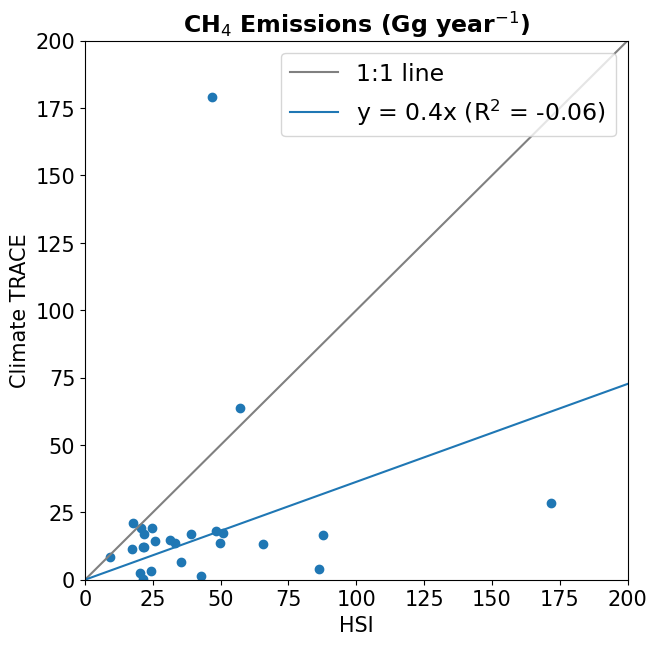

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df_merge_ct['HSI'].values
xerr = x * df_merge_ct['HSI uncertainty (%)'] *1e-2
y = df_merge_ct['Climate TRACE'].values

# Reshape the arrays to 2D
x_2d = x.reshape(-1, 1)
y_2d = y.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(x_2d, y_2d)

# Get the slope of the linear regression line
slope = model.coef_[0][0]

# Calculate R-squared
r_squared = model.score(x_2d, y_2d)

plt.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
plt.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')

ax.scatter(x, y)

ax.set_xlabel('HSI')
ax.set_ylabel('Climate TRACE')
ax.set_title('CH$_4$ Emissions (Gg year$^{-1}$)')

ax.set_xlim(0, 200)
ax.set_ylim(0, 200)

plt.legend()

# fig.savefig('../figures/hsi_climatetrace_fit.pdf')

## Matrix plot

In [10]:
def plot_stats(df):
    # https://stackoverflow.com/a/50690729/7347925
    def corrdot(*args, **kwargs):
        corr_r = args[0].corr(args[1], 'pearson')
        corr_text = f"{corr_r:2.2f}".replace("0.", ".")
        ax = plt.gca()
        ax.set_axis_off()
        marker_size = abs(corr_r) * 10000
        ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
                vmin=-1, vmax=1, transform=ax.transAxes)
        font_size = abs(corr_r) * 40 + 5
        ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                    ha='center', va='center', fontsize=font_size)

    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)

In [11]:
# plot_stats(df_merge[['emission', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity']])

## OBS

In [12]:
df_merge_obs = df_obs.merge(df_merge[['name', 'emission', 'emission_uncertainty(%)']], on='name', how='left')

# keep landfills which have both HSI and OBS
df_merge_obs_nonan = df_merge_obs.dropna(subset=['emission_obs', 'emission']).reset_index(drop=True)

In [13]:
df_merge_obs

,country,name,latitude,longitude,emission(t/h),uncertainty(t/h),year,source,Reference,emission_obs,uncertainty_obs,emission,emission_uncertainty(%)
0,Argentina,González Catán,-34.785823,-58.666450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.788455,41.921696
1,Argentina,Norte III,-34.529123,-58.622229,21.90,7.80,2021,GHGSat,https://doi.org/10.1126/sciadv.abn9683,191.8440,68.3280,171.880604,35.267763
2,Argentina,Piedra Blanca,-31.518877,-64.235094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.160607,37.402921
3,Bangladesh,Aminbazar,23.798009,90.299357,2.17,NaN,2021,In-situ,https://doi.org/10.1016/j.cscee.2023.100302,19.0092,NaN,33.086285,55.540671
4,Brazil,Pedreira,-23.403868,-46.560920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.121929,37.616219
5,Brazil,São Paulo,-23.351949,-46.776142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.340958,37.576156
6,China,Ürümqi,44.039022,87.865791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.108367,46.245832
7,India,Bandhwari,28.402440,77.171418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.260313,42.772710
8,India,Bhalswa,28.741570,77.156534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.476132,43.519654
9,India,Deonar,19.072684,72.928106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.743984,45.020928


## Climate Trace top 20 landfills

### Validate csv and excel files

In [14]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [15]:
top20_dir = '../data/Hyper_ClimateTrace20/'

filelist = list(chain(*[glob(os.path.join(top20_dir, '**', '*csv'), recursive=True)]))

df_top20 = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)
df_top20['emission_uncertainty(%)'] = df_top20['emission_uncertainty']/df_top20['emission']*100
# convert units from kg/h to Gg/yr
df_top20['emission'] = df_top20['emission'] / 1e6 * 365 *24

df_top20_emiss = df_top20.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count'})

# remove space at end
df_top20_emiss['name'] = df_top20_emiss['name'].str.strip()

In [16]:
validate_name(df_top20_emiss, df_hyper_top20)

All csv landfill names are in the excel file


In [17]:
df_top20_emiss['count'], df_top20_emiss['overpass'] = zip(*df_top20_emiss.apply(append_excel_data, args=(df_hyper_top20,), axis=1))

# this should be empty
df_top20_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass


### Calculate mean emission and add Climate TRACE data

In [18]:
# assume 0 emission for no plume
df_top20_emiss['emission_mean'] = df_top20_emiss['emission']*df_top20_emiss['plume_count']/df_top20_emiss['overpass']
df_top20_emiss['emission_ratio'] = df_top20_emiss['emission_mean']/df_top20_emiss['emission']

In [19]:
df_top20_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass,emission_mean,emission_ratio
0,Chile,Loma Los Colorados,EMIT,-70.797246,-32.957113,83.395206,43.428844,2,2,2,83.395206,1.000000
1,China,West New Territories,EMIT,113.933249,22.418804,34.218126,45.618085,1,1,1,34.218126,1.000000
2,China,West New Territories,EnMAP,113.932410,22.419062,34.399061,38.628011,1,1,1,34.399061,1.000000
3,Greece,Fyli,EMIT,23.649628,38.075325,182.661282,39.937469,1,1,2,91.330641,0.500000
4,Iran,Tehran,EMIT,51.330033,35.458738,46.861008,39.942797,9,9,9,46.861008,1.000000
5,Jordan,Ghabawi,EMIT,36.187411,31.930061,58.407225,34.257982,14,14,14,58.407225,1.000000
6,Mexico,Los Laureles,PRISMA,-103.174977,20.545968,30.097452,56.316605,1,1,1,30.097452,1.000000
7,Mexico,Relleno Sanitario Portezuelos,EMIT,-116.744077,32.407891,60.057825,43.913623,4,4,4,60.057825,1.000000
8,Mexico,Relleno Sanitario Portezuelos,PRISMA,-116.747716,32.405726,87.136020,41.746066,1,1,1,87.136020,1.000000
9,Mexico,Relleno Sanitario Puebla,EMIT,-98.138243,18.982475,16.587781,54.768569,1,1,3,5.529260,0.333333


### Merge all data for TOP 20 landfills

In [20]:
# merge HSI and OBS
df_merge_all = df_top20_emiss[['country', 'name', 'platform', 'emission_mean', 'emission_uncertainty(%)']]\
    .merge(df_merge_obs[['country', 'name', 'emission_obs', 'uncertainty_obs', 'emission', 'emission_uncertainty(%)']],
                     on=['country', 'name'], how='left')

# add climate trace 20
df_merge_all = df_merge_all.merge(df_climatetrace[['name', 'emissions_quantity']], on='name', how='left')

# merge HSI emission
df_merge_all['HSI'] = df_merge_all[['emission_mean', 'emission']].bfill(axis=1).iloc[:, 0]
df_merge_all['emission_uncertainty(%)'] = df_merge_all[['emission_uncertainty(%)_x', 'emission_uncertainty(%)_y']].bfill(axis=1).iloc[:, 0]

# rename columns for plot
df_merge_all.rename(columns={'emissions_quantity': 'Climate TRACE', 'emission_obs': 'OBS',
                             'emission_uncertainty(%)': 'HSI uncertainty (%)',
                             'uncertainty_obs': 'OBS uncertainty',
                            },
                    inplace=True
                    )

# average HSI emissions of same landfill
df_merge_all = df_merge_all.groupby(['country', 'name'])[['Climate TRACE', 'HSI', 'HSI uncertainty (%)', 'OBS', 'OBS uncertainty']].mean().reset_index()

# sort by Climate TRACE emission data
df_merge_all = df_merge_all.sort_values('Climate TRACE', ascending=False).reset_index(drop=True)

# calculate and rename again for table
df_merge_all['OBS uncertainty (%)'] = df_merge_all['OBS uncertainty']/df_merge_all['OBS']*100
df_merge_all.rename(columns={'country': 'Country', 'name': 'Name'}, inplace=True)

# modify name for xaxis
df_merge_all['xname'] = df_merge_all['Name'] + ' (' + df_merge_all['Country'] + ')'

In [21]:
df_merge_all

,Country,Name,Climate TRACE,HSI,HSI uncertainty (%),OBS,OBS uncertainty,OBS uncertainty (%),xname
0,Iran,Tehran,179.19410,46.861008,39.942797,43.8000,8.760,20.000000,Tehran (Iran)
1,Mexico,Simeprodeso,156.50945,48.375957,46.511546,NaN,NaN,NaN,Simeprodeso (Mexico)
2,Chile,Loma Los Colorados,103.63746,83.395206,43.428844,7.9716,1.752,21.978022,Loma Los Colorados (Chile)
3,Mexico,Los Laureles,103.60157,30.097452,56.316605,NaN,NaN,NaN,Los Laureles (Mexico)
4,Greece,Fyli,89.21826,91.330641,39.937469,NaN,NaN,NaN,Fyli (Greece)
5,Mexico,Relleno Sanitario Portezuelos,81.17740,73.596922,42.829844,NaN,NaN,NaN,Relleno Sanitario Portezuelos (Mexico)
6,China,West New Territories,74.93260,34.308593,42.123048,NaN,NaN,NaN,West New Territories (China)
7,Mexico,Relleno Sanitario Puebla,68.27572,5.529260,54.768569,NaN,NaN,NaN,Relleno Sanitario Puebla (Mexico)
8,Jordan,Ghabawi,63.67634,58.407225,34.257982,NaN,NaN,NaN,Ghabawi (Jordan)


In [22]:
# print latex table
print(df_merge_all[['Country', 'Name', 'Climate TRACE',	'HSI', 'HSI uncertainty (%)', 'OBS', 'OBS uncertainty',	'OBS uncertainty (%)']].to_latex(index=False, float_format=lambda x: '%10.2f' % x))

\begin{tabular}{llrrrrrr}
\toprule
Country & Name & Climate TRACE & HSI & HSI uncertainty (%) & OBS & OBS uncertainty & OBS uncertainty (%) \\
\midrule
Iran & Tehran &     179.19 &      46.86 &      39.94 &      43.80 &       8.76 &      20.00 \\
Mexico & Simeprodeso &     156.51 &      48.38 &      46.51 & NaN & NaN & NaN \\
Chile & Loma Los Colorados &     103.64 &      83.40 &      43.43 &       7.97 &       1.75 &      21.98 \\
Mexico & Los Laureles &     103.60 &      30.10 &      56.32 & NaN & NaN & NaN \\
Greece & Fyli &      89.22 &      91.33 &      39.94 & NaN & NaN & NaN \\
Mexico & Relleno Sanitario Portezuelos &      81.18 &      73.60 &      42.83 & NaN & NaN & NaN \\
China & West New Territories &      74.93 &      34.31 &      42.12 & NaN & NaN & NaN \\
Mexico & Relleno Sanitario Puebla &      68.28 &       5.53 &      54.77 & NaN & NaN & NaN \\
Jordan & Ghabawi &      63.68 &      58.41 &      34.26 & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



## Combination into one plot

In [23]:
def fit_line(x, y):
    # Reshape the arrays to 2D
    x_2d = x.reshape(-1, 1)
    y_2d = y.reshape(-1, 1)

    # Create and fit the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(x_2d, y_2d)

    # Get the slope of the linear regression line
    slope = model.coef_[0][0]
    print(model.intercept_)

    # Calculate R-squared
    r_squared = model.score(x_2d, y_2d)

    return slope, r_squared

0.0
0.0


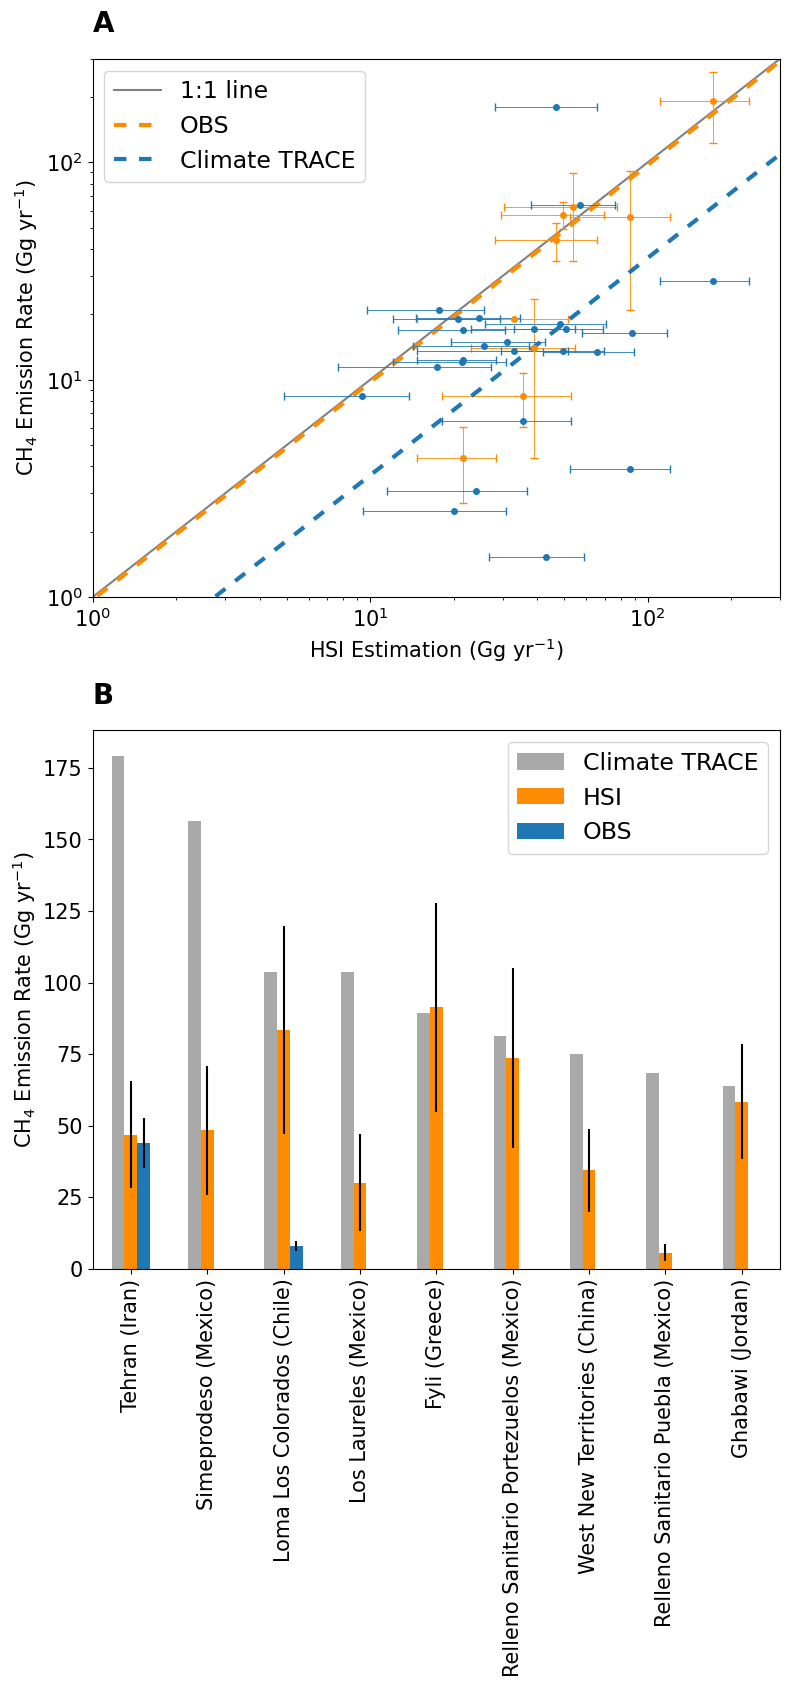

In [24]:
fig, axs = plt.subplots(figsize=(8, 17), nrows=2)

axs = axs.flatten()

# ---- HSI v.s. OBS ---
ax = axs[0]

l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')

x = df_merge_obs_nonan['emission'].values
xerr = x * df_merge_obs_nonan['emission_uncertainty(%)'] *1e-2
y = df_merge_obs_nonan['emission_obs'].values
yerr = df_merge_obs_nonan['uncertainty_obs'].values

# import statsmodels.formula.api as smf
# model = smf.ols('y~ x - 1', data={'x': x, 'y': y}).fit()
# slope = model.params['x']
# rsquared = model.rsquared

slope, r_squared = fit_line(x, y)
# l3 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='darkorange', linestyle='--')
# l3 = ax.axline(xy1=(0, 0), slope=slope, label='OBS', c='darkorange', linestyle='--')
ax.plot(range(300), slope*range(300), label='OBS', c='darkorange', linestyle='--', dashes=(3, 3), linewidth=3)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6, c='darkorange')

# ---- HSI v.s. Climate TRACE ---

x = df_merge_ct['HSI'].values
xerr = x * df_merge_ct['HSI uncertainty (%)'] *1e-2
y = df_merge_ct['Climate TRACE'].values

slope, r_squared = fit_line(x, y)

# l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0', linestyle='--')
# l2 = ax.axline(xy1=(0, 0), slope=slope, label='Climate TRACE', c='C0', linestyle='--')
ax.plot(range(300), slope*range(300), label='Climate TRACE', c='C0', linestyle='--', dashes=(3, 3), linewidth=3)

# ax.scatter(x, y)
ax.errorbar(x, y, xerr=xerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6)

ax.set_xlabel('HSI Estimation (Gg yr$^{-1}$)')
ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')

ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1, 300)
ax.set_ylim(1, 300)

# ---- TOP 20 Climate Trace ----
ax = axs[1]

df_merge_all.plot(ax=ax,
                x='xname', y=['Climate TRACE', 'HSI', 'OBS'],
                yerr=[[0]*len(df_merge_all),
                        df_merge_all['HSI']*df_merge_all['HSI uncertainty (%)']*1e-2,
                        df_merge_all['OBS uncertainty'],
                        ],
                kind="bar",
                color=['darkgrey', 'darkorange', 'C0'],
                rot=90,
                )
ax.set_xlabel('')
ax.set_ylabel('CH$_4$ Emission Rate (Gg yr$^{-1}$)')
ax.set_ylim(ymin=0)

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.05, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/emission_comp.pdf')